<a href="https://colab.research.google.com/github/ChrisDieck/food-sales-predictions/blob/main/food_sales_predictions_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(display='diagram')

In [ ]:
filename = '/content/drive/MyDrive/02 Week 2: Pandas/Coding Data/sales_predictions.csv'
df = pd.read_csv(filename)

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data Cleaning

In [ ]:
#There are 8523 rows and 12 columns
df.shape

(8523, 12)

In [ ]:
#Checking Datatypes
df.dtypes

Item_Identifier          object
Item_Weight             float64
Item_Fat_Content         object
Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
Item_Outlet_Sales       float64
dtype: object

##Checking for and Deleting Duplicates

In [ ]:
df.duplicated().sum() #there are no duplicates
df= df.drop(columns= ['Outlet_Identifier', 'Outlet_Establishment_Year'])
# also dropping unneccessary columns

## Preprocessing for Machine Learning

In [ ]:
#making a separate dataframe for machine learning
df2 = df.copy()

In [ ]:
#Ordinal Encoding columns before splitting data
#Outlet Size
df2['Outlet_Size'].replace({'Small':0, 'Medium':1, 'High':2}, inplace=True)

#Outlet Location Type
df2['Outlet_Location_Type'].replace({'Tier 1':0, 'Tier 2':1, 'Tier 3':2}, inplace=True)

I chose to ordinal encode these because the machine learning models will treat each one as a higher or lesser value to each other.

I did not ordinal encode Outlet Type because it is unknown if 'Grocery Store' would be higher than 'Supermarket Type3' or lower than 'Supermarket Type1'.

In [ ]:
#splitting data for machine learning before making imputations for numerical columns
X = df2.drop(['Item_Outlet_Sales','Item_Identifier'], axis=1)
y = df2['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Selectors for Categorical and Numerical columns
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

Instantiating Transformers

I chose to impute missing categorical values with the most frequent inputs because these columns have a much higher amount of one input compared to the others and it should preserve the relationships between the variables.

I chose to use a median imputer for the numerical columns because the data is skewed, so this should preserve the relationships between the variables.

In [ ]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

Instantiating Pipelines

In [ ]:
# Numeric pipeline
numeric_pipe = make_pipeline(median_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
# Categorical pipelines
categorical_pipe = make_pipeline(freq_imputer, ohe)

Instantiating ColumnTransformer

In [ ]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa130cdddd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa130cdde50>)])

Fitting Transformer to Training Data

In [ ]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa130cdddd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa130cdde50>)])

Transforming Data

In [ ]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Looking at Results

In [ ]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 30)




array([[ 0.82748547, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56664432, -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12102782,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12389588, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.77599877, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82748547, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

Data is now ready for Machine Learning.

## Linear Regression Model To Predict Sales

In [ ]:
#Instantiating the model
reg = LinearRegression()

#Creating a modeling pipeline
reg_pipe = make_pipeline(scaler,reg)

#Training the model on training data
reg_pipe.fit(X_train_processed,y_train)

#Making predictions on testing data and training data
train_preds = reg_pipe.predict(X_train_processed)
test_preds = reg_pipe.predict(X_test_processed)

In [ ]:
#Evaluation of model with R2
reg_train_score = reg_pipe.score(X_train_processed,y_train)
reg_test_score = reg_pipe.score(X_test_processed,y_test)
print(f'The R^2 Score for the training data is: {reg_train_score:,.2}')
print(f'The R^2 Score for the testing data is: {reg_test_score:,.2}')

The R^2 Score for the training data is: 0.56
The R^2 Score for the training data is: 0.57


In [ ]:
#Evaluation of model with RMSE

#Getting MSE first
train_MSE = mean_squared_error(y_train, train_preds)
test_MSE = mean_squared_error(y_test, test_preds)

#RMSE
train_RMSE = np.sqrt(train_MSE)
test_RMSE = np.sqrt(test_MSE)

#Results
print(f'The RMSE for the training data is: {train_RMSE:,.6}')
print(f'The RMSE for the testing data is: {test_RMSE:,.6}')

The RMSE for the training data is: 1,140.29
The RMSE for the testing data is: 1,094.67


Unfortunately, this linear regression model has poor results with an R2 score of %56.5 and an RMSE of $1094, which means the model is making some fairly large errors and cannot account for almost half of the variances.

## Random Forest Model to Predict Sales

In [ ]:
#Instantiating model
rf = RandomForestRegressor(random_state = 42)

#Fitting model to training data
rf.fit(X_train_processed,y_train)

#Predicting values for y
rf.predict(X_test_processed)

#Evaluating scores with R2
rf_train_score = rf.score(X_train_processed, y_train)
rf_test_score = rf.score(X_test_processed, y_test)
print(rf_train_score)
print(rf_test_score)

0.9362060200358988
0.5434468801513985


Not good results so far.

### Tuning the model for the optimal max_depth

In [ ]:
#checking what the highest max depth can be
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

43

In [ ]:
#Running a loop to test for the best max depth
depths = range(1, max(est_depths))
scores = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   model = RandomForestRegressor(max_depth=depth, random_state = 42)
   model.fit(X_train_processed, y_train)
   scores.loc[depth, 'Train Score'] = model.score(X_train_processed, y_train)
   scores.loc[depth, 'Test Score'] = model.score(X_test_processed, y_test)
   scores.head()

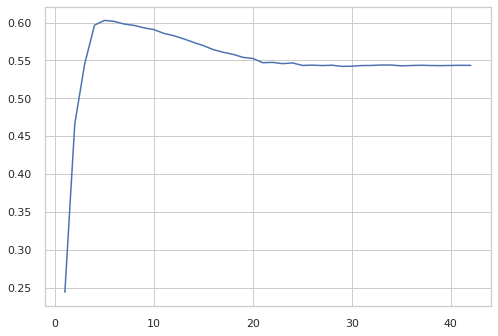

In [ ]:
#Plotting the Scores
plt.plot(scores['Test Score'])

In [ ]:
#Sorting the scores to see the best max_depth
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.60276,0.610587
6,0.601434,0.624385
7,0.597934,0.642709
4,0.596635,0.595925
8,0.596172,0.664714


In [ ]:
#Tuning the n_estimators by using a for loop to test different values with best max_depth
n_ests = [50, 100, 150, 200, 250]
scores2 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])
for n in n_ests:
   model = RandomForestRegressor(max_depth=5, n_estimators=n, random_state = 42)
   model.fit(X_train_processed, y_train)
   scores2.loc[n, 'Train Score'] = model.score(X_train_processed, y_train)
   scores2.loc[n, 'Test Score'] = model.score(X_test_processed, y_test)
scores2.head()

,Test Score,Train Score
50,0.60115,0.610699
100,0.60276,0.610587
150,0.603117,0.610398
200,0.603036,0.610393
250,0.603072,0.610502


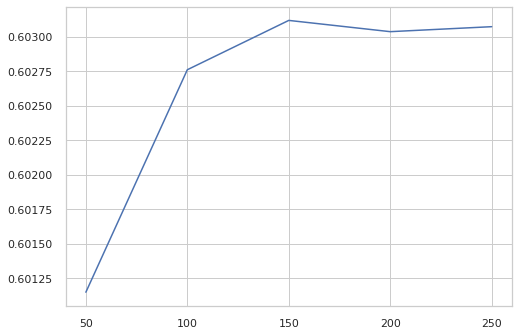

In [ ]:
#Plotting Results again
plt.plot(scores2['Test Score'])
plt.xticks(n_ests);

In [ ]:
#Sorting Best Score
sorted_scores2 = scores2.sort_values(by='Test Score', ascending=False)
sorted_scores2.head()

,Test Score,Train Score
150,0.603117,0.610398
250,0.603072,0.610502
200,0.603036,0.610393
100,0.60276,0.610587
50,0.60115,0.610699


The n_estimators did not make much of a difference, but this model has a better R2 score of 60% when compared to the 56.5% of the linear regression model

In [180]:
#Instantiating best model
rf_best = RandomForestRegressor(max_depth= 5, n_estimators= 150, random_state = 42)

#Fitting best model to training data
rf_best.fit(X_train_processed,y_train)

#Predicting values for y
train_preds2 = rf_best.predict(X_train_processed)
test_preds2 = rf_best.predict(X_test_processed)

In [181]:
#Evaluation of model with RMSE using the best version of the model

#Getting MSE first
train_MSE2 = mean_squared_error(y_train, train_preds2)
test_MSE2 = mean_squared_error(y_test, test_preds2)

#RMSE
train_RMSE2 = np.sqrt(train_MSE2)
test_RMSE2 = np.sqrt(test_MSE2)

#Results
print(f'The RMSE for the training data is: {train_RMSE2:,.6}')
print(f'The RMSE for the testing data is: {test_RMSE2:,.6}')

The RMSE for the training data is: 1,073.78
The RMSE for the testing data is: 1,046.42


##Identifying and Filling Missing Values Manually on Original DataFrame

In [ ]:
df.isna().sum() #Item_Weight and Outlet_Size are the only columns with missing values

Item_Identifier            0
Item_Weight             1463
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

### To Fill Missing Values in 'Item_Weight' Manually

In [ ]:
df['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

In [ ]:
df['Item_Weight'].median()

12.6

In [ ]:
#filling missing item weights with the average item weight because the data is skewed
average_item_weight = df['Item_Weight'].mean()
df['Item_Weight'].fillna(average_item_weight, inplace = True)
df.isna().sum()

Item_Identifier            0
Item_Weight                0
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

### To Fill Missing Values for 'Outlet_Size' Manually

In [ ]:
#checking for most common size
df['Outlet_Size'].value_counts('')

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [ ]:
#imputing missing values with the most common size until further research can be done
df['Outlet_Size'].fillna('Medium', inplace=True)

In [ ]:
#there are no more missing values
df.isna().sum()

Item_Identifier         0
Item_Weight             0
Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
Item_Outlet_Sales       0
dtype: int64

##Finding and Fixing Any Inconsistence Categories

In [ ]:
#to see which categories I should look at
df.nunique()

Item_Identifier         1559
Item_Weight              416
Item_Fat_Content           5
Item_Visibility         7880
Item_Type                 16
Item_MRP                5938
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
Item_Outlet_Sales       3493
dtype: int64

In [ ]:
#checking the names of the 'Item_Type' column
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [ ]:
#checking the names of the 'Outlet_Type' column
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
#found inconsistent value types
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
#consolidated inconsistent value types into 2 main types (Low Fat and Regular)
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg','Regular')

In [ ]:
#checking results
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

##Summary Statistics of Each Numerical Column

In [ ]:
#need summary stats of Item_Weight, Item_Visibility, Item_MRP, and Item_Outlet_Sales because they are floats
df.dtypes

Item_Identifier          object
Item_Weight             float64
Item_Fat_Content         object
Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
Item_Outlet_Sales       float64
dtype: object

In [ ]:
#summary stats of numerical columns
dfnum = df[['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']] #consolidating all numerical columns
dfnum.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.226124,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,9.310000,0.026989,93.826500,834.247400
50%,12.857645,0.053931,143.012800,1794.331000
75%,16.000000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


# Data Exploration

In [ ]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.226124,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,9.310000,0.026989,93.826500,834.247400
50%,12.857645,0.053931,143.012800,1794.331000
75%,16.000000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


### Histograms showing the frequency of each nominal column

Outlet Type

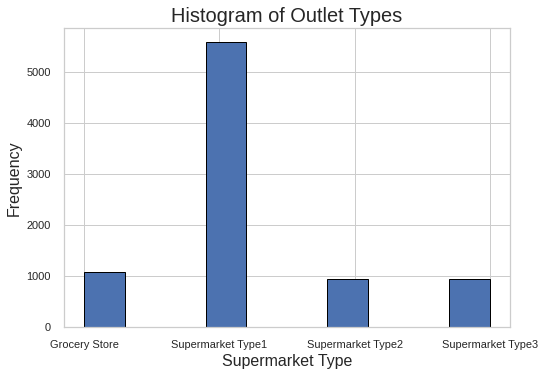

In [ ]:
plt.hist(df['Outlet_Type'].sort_values(),
         edgecolor = 'black')
plt.style.use('seaborn')
plt.xlabel('Supermarket Type', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Histogram of Outlet Types', fontsize = 20);

This histogram shows that there is an overwhelmingly higher amount of Supermarket Type 1 compared to the other outlet types.

Location Type

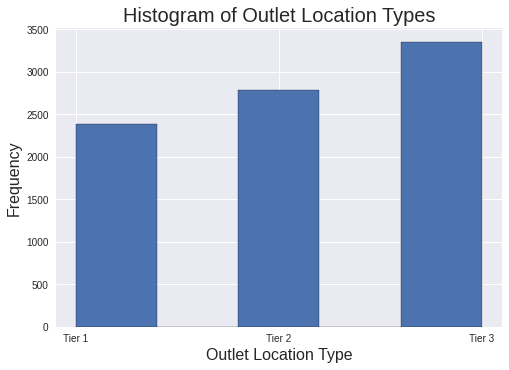

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
plt.hist(df['Outlet_Location_Type'].sort_values(),
         bins = 5,
         edgecolor = 'black')
plt.style.use('seaborn')
plt.xlabel('Outlet Location Type', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Histogram of Outlet Location Types', fontsize = 20)
plt.show();

df['Outlet_Location_Type'].value_counts()

This histogram shows that there is mostly Tier 3 locaiton types, with tier 2 and tier 1 following, respectively.

Outlet Size

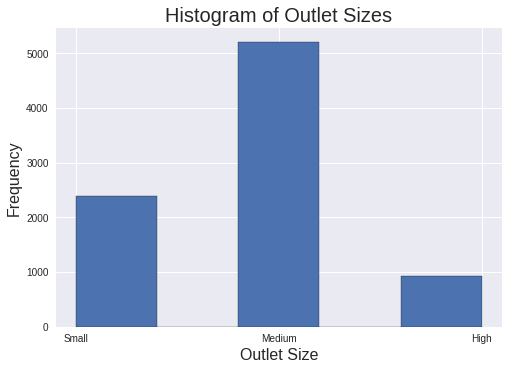

Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [ ]:
#this is skewed due to the missing values being filled with the 'Medium' value
plt.hist(df['Outlet_Size'].sort_values(ascending=False),
         bins = 5,
         edgecolor = 'black')
plt.style.use('seaborn')
plt.xlabel('Outlet Size', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Histogram of Outlet Sizes', fontsize = 20)
plt.show();

df['Outlet_Size'].value_counts()

This histogram shows that there is mostly medium-sized outlets. Small and high follow, respectively.

Item Type

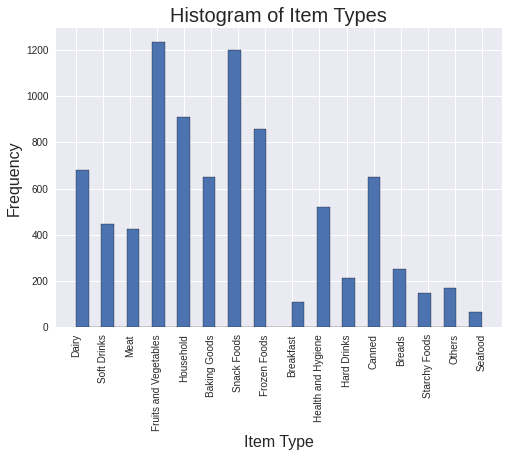

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [ ]:
plt.hist(df['Item_Type'],
         bins = 32,        
         edgecolor = 'black')
plt.xticks(rotation = 90)
plt.style.use('seaborn')
plt.xlabel('Item Type', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Histogram of Item Types', fontsize = 20)
plt.show();

df['Item_Type'].value_counts()

This histogram shows the distribution of different item types with 'Fruits and Vegetables' and 'Snack Foods', respectively, being the highest.

Fat Content

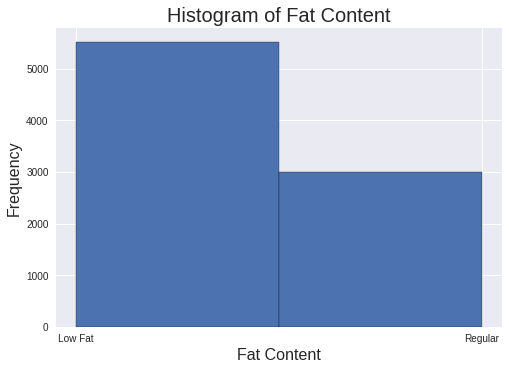

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
plt.hist(df['Item_Fat_Content'],
         bins = 2,
         edgecolor = 'black')
plt.style.use('seaborn')
plt.xlabel('Fat Content', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Histogram of Fat Content', fontsize = 20)
plt.show();

df['Item_Fat_Content'].value_counts()

This histogram shows that there is about 2500 more items with low fat content compared to high fat content.

## Boxplots for Nominal-Numerical Data

### Outlet Type and Sales

Boxplot showing the sales distribution for Outlet Types

In [ ]:
df.groupby('Outlet_Type')['Item_Outlet_Sales'].median()

Outlet_Type
Grocery Store         256.9988
Supermarket Type1    1990.7420
Supermarket Type2    1655.1788
Supermarket Type3    3364.9532
Name: Item_Outlet_Sales, dtype: float64

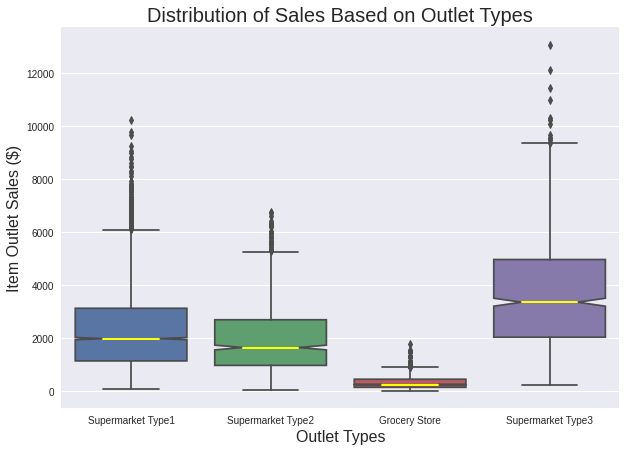

Outlet_Type
Grocery Store         256.9988
Supermarket Type1    1990.7420
Supermarket Type2    1655.1788
Supermarket Type3    3364.9532
Name: Item_Outlet_Sales, dtype: float64

In [ ]:
fig, axes = plt.subplots(figsize = (10,7))
boxplots = sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df,
                       notch = True,
                       medianprops = dict(linestyle='-',linewidth=2,color='Yellow'))
plt.xlabel('Outlet Types', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Distribution of Sales Based on Outlet Types', fontsize = 20)
plt.show();
df.groupby('Outlet_Type')['Item_Outlet_Sales'].median()

These boxplots show that the median sales for each outlet type are not far from each other, however grocery stores have the lowest sales and supermarket type 3's have the highest sales.

*Note: There also appears to be many outliers in this data.

### Location Type and Sales

Boxplot showing the sales distribution for Outlet Location Types

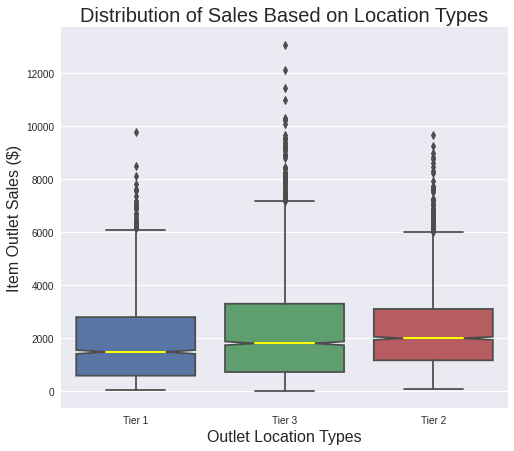

Outlet_Location_Type
Tier 1    1487.3972
Tier 2    2004.0580
Tier 3    1812.3076
Name: Item_Outlet_Sales, dtype: float64

In [ ]:
fig, axes = plt.subplots(figsize = (8,7))
sns.boxplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=df,
            notch = True,
            medianprops = dict(linestyle='-',linewidth=2,color='Yellow'))
plt.xlabel('Outlet Location Types', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Distribution of Sales Based on Location Types', fontsize = 20);
plt.show();
df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].median()

### Outlet Size and Sales

Boxplot showing the sales distribution for Outlet Sizes

Text(0.5, 1.0, 'Distribution of Sales Based on Outlet Sizes')

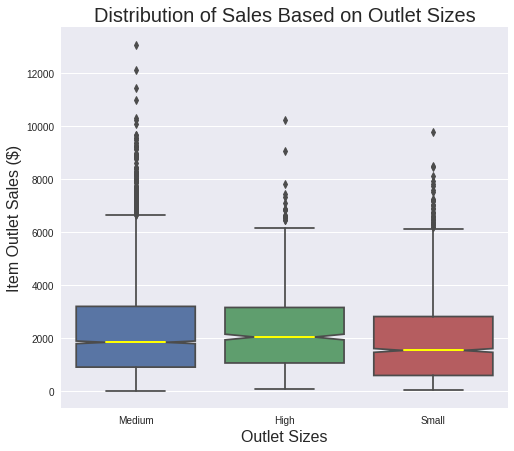

In [ ]:
fig, axes = plt.subplots(figsize = (8,7))
boxplots = sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df,
                       notch = True,
                       medianprops = dict(linestyle='-',linewidth=2,color='Yellow'))
plt.xlabel('Outlet Sizes', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Distribution of Sales Based on Outlet Sizes', fontsize = 20)

### Item Type and Sales

Boxplot showing the sales distribution for Outlet Sizes

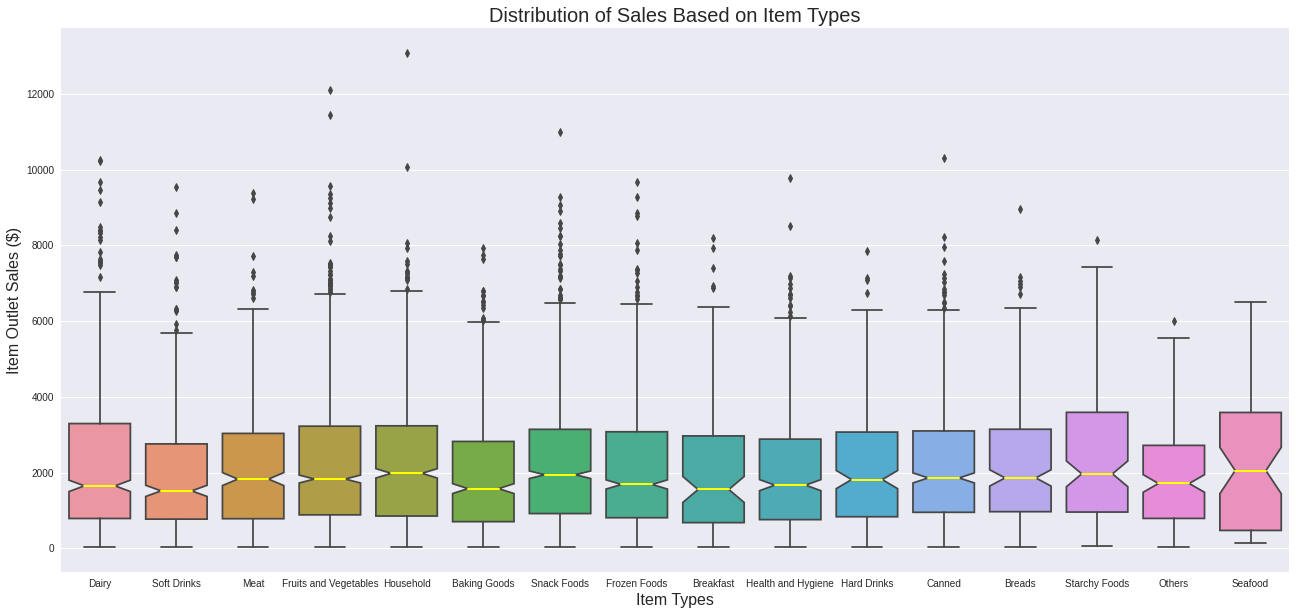

Item_Type
Baking Goods             1577.9460
Breads                   1860.2452
Breakfast                1554.6430
Canned                   1860.2452
Dairy                    1650.8511
Frozen Foods             1687.1372
Fruits and Vegetables    1830.9500
Hard Drinks              1816.6353
Health and Hygiene       1669.4935
Household                1981.4208
Meat                     1829.6184
Others                   1713.7692
Seafood                  2055.3246
Snack Foods              1944.1360
Soft Drinks              1518.0240
Starchy Foods            1968.1048
Name: Item_Outlet_Sales, dtype: float64

In [ ]:
fig, axes = plt.subplots(figsize = (22,10))
boxplots = sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=df,
                       notch = True,
                       medianprops = dict(linestyle='-',linewidth=2,color='Yellow'))
plt.xlabel('Item Types', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Distribution of Sales Based on Item Types', fontsize = 20)
plt.show();
df.groupby('Item_Type')['Item_Outlet_Sales'].median()

Bar Chart of Sales for each Item Type

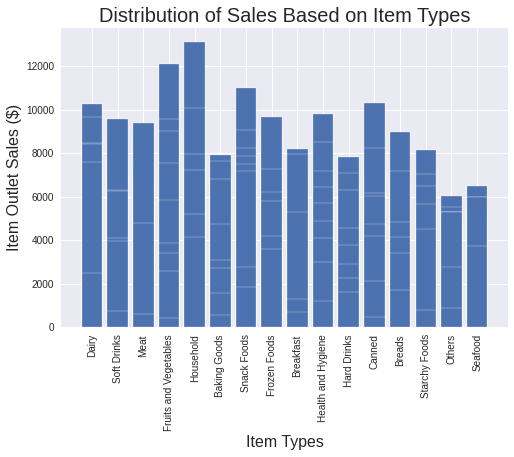

In [ ]:
plt.bar(df['Item_Type'],df['Item_Outlet_Sales'])
plt.xticks(rotation = 90)
plt.title('Distribution of Sales Based on Item Types')
plt.xlabel('Item Types', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Distribution of Sales Based on Item Types', fontsize = 20);

### Fat Content and Sales

Boxplot showing the sales distribution for Fat Content

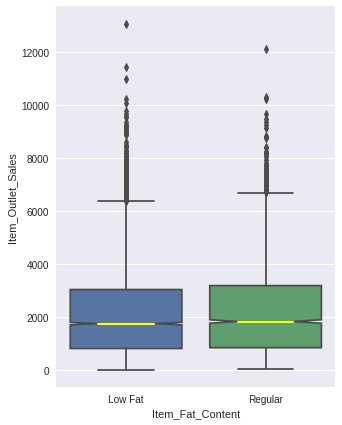

In [ ]:
fig, axes = plt.subplots(figsize = (5,7))
sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=df,
            notch = True,
            medianprops = dict(linestyle='-',linewidth=2,color='Yellow'));

## Scatter Plots for Numerical-Numerical Data

### Item MRP and Sales

Scatter Plot showing Sales as Item MRP increases



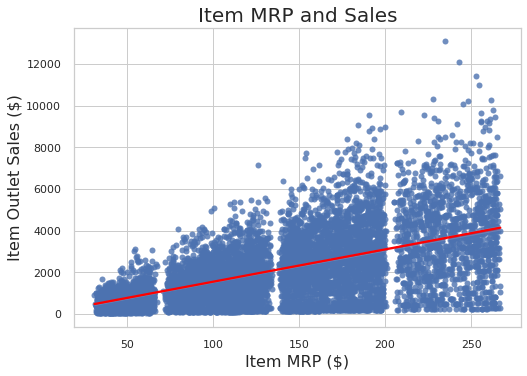

In [ ]:
sns.set(style = 'whitegrid')
sns.regplot(data=df,x='Item_MRP',y='Item_Outlet_Sales',
            line_kws={'color':'red'},
            fit_reg = True)
plt.xlabel('Item MRP ($)', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Item MRP and Sales', fontsize = 20);

This distribution shows us that item sales tend to increase as item MRP increases.

### Item Visibility and Sales

Scatter Plot showing Sales as Item Visibility increases

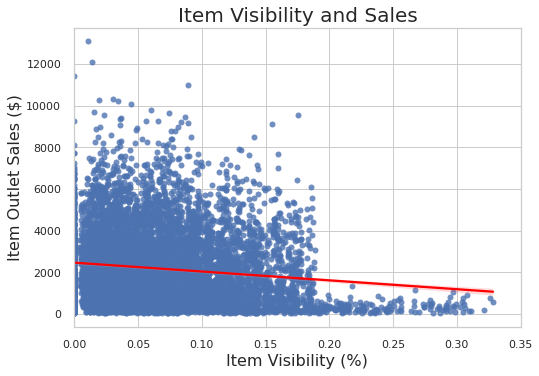

In [ ]:
sns.regplot(data=df,x='Item_Visibility',y='Item_Outlet_Sales',
            line_kws={'color':'red'},
            fit_reg = True)
plt.xlim(left=0,right=.35)
plt.xlabel('Item Visibility (%)', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Item Visibility and Sales', fontsize = 20);

This scatterplot shows us that there is a sudden drop-off of sales after visibility reaches about .18%

### Item_Weight and Sales

Scatter Plot showing Sales as Item Weight increases

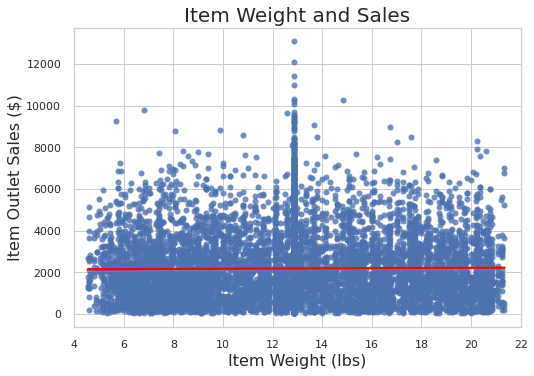

In [ ]:
sns.regplot(data=df,x='Item_Weight',y='Item_Outlet_Sales',
            line_kws={'color':'red'},
            fit_reg = True)
plt.xlim(left=4,right=22)
plt.xlabel('Item Weight (lbs)', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Item Weight and Sales', fontsize = 20);

This scatterplot shows that item weight does not seem to have any correlation with sales. 

*Also note that the values are skewed due to missing values being imputed with the median value.

## Correlations

Heatmap to Show Correlations

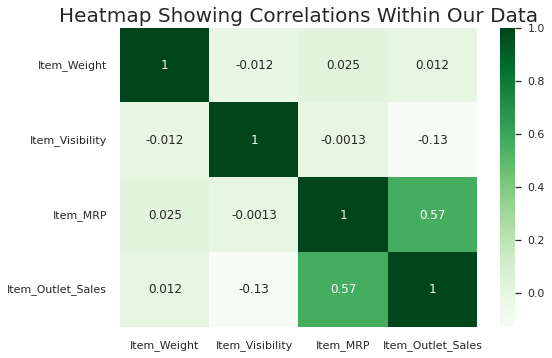

In [ ]:
#to show the correlations between the numerical data
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True)
plt.title('Heatmap Showing Correlations Within Our Data', fontsize=20);

Item MRP is the only column that has at least a moderate correlation to Sales. Everything else seems to have a weak positive correlation except for Item Visibility, which has a weak negative correlation with each column.

# Most Important Data Visualizations

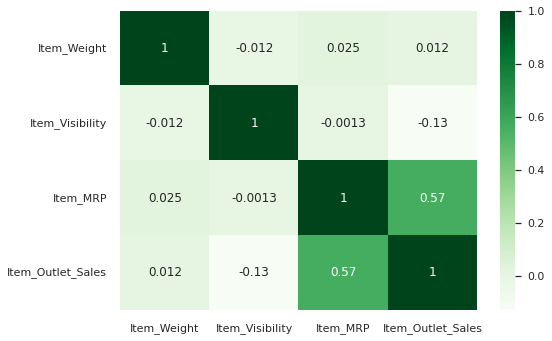

In [ ]:
#to show the correlations between the numerical data
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True);

This heatmap shows that the two variables with the stronget correlations with item outlet sales is are Item MRP (moderate) and item visibility (weak, but our second strongest correlation). The rest of the variables, unfortunately, have extremely weak correlations to sales.

## Item MRP and Sales

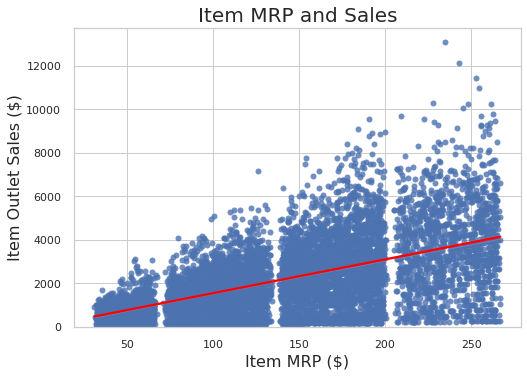

In [ ]:
sns.set(style = 'whitegrid')
sns.regplot(data=df,x='Item_MRP',y='Item_Outlet_Sales',
            line_kws={'color':'red'},
            fit_reg = True)
plt.ylim(bottom=0)
plt.xlabel('Item MRP ($)', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Item MRP and Sales', fontsize = 20);

This scatterplot shows a clear and steady increase of sales as the material requirements planning increases for items.

This is our best indicator for making sales predictions compared to the rest of our variables.

## Item Visibility and Sales

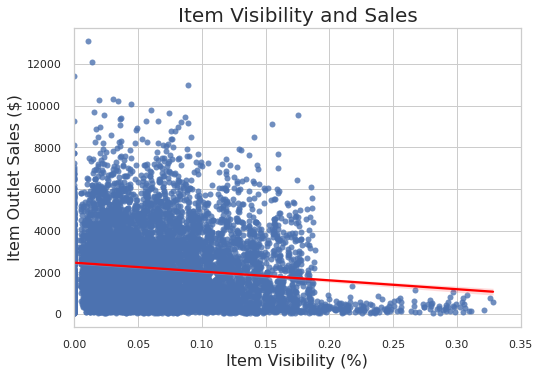

In [ ]:
sns.regplot(data=df,x='Item_Visibility',y='Item_Outlet_Sales',
            line_kws={'color':'red'},
            fit_reg = True)
plt.xlim(left=0,right=.35)
plt.xlabel('Item Visibility (%)', fontsize = 16)
plt.ylabel('Item Outlet Sales ($)', fontsize = 16)
plt.title('Item Visibility and Sales', fontsize = 20);

This scatterplot shows us that there is a sudden drop-off of sales after visibility reaches about 0.18%.

This trend in the data seems counter-intuitive to what one might expect, and may be worth looking further into.

Also, with this variable having the second highest correlation with sales, it should be our second best variable for predicting future sales.

## Outlet Type and Sales

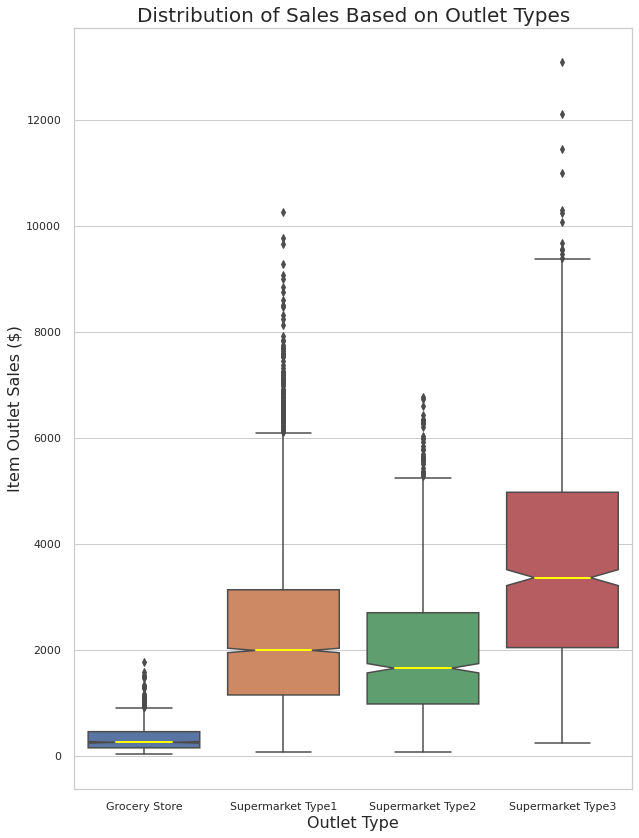

Outlet_Type
Grocery Store         256.9988
Supermarket Type1    1990.7420
Supermarket Type2    1655.1788
Supermarket Type3    3364.9532
Name: Item_Outlet_Sales, dtype: float64

In [ ]:
fig, axes = plt.subplots(figsize = (10,14))
boxplots = sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df,
                       notch = True,
                       medianprops = dict(linestyle='-',linewidth=2,color='Yellow'),
                       order=['Grocery Store','Supermarket Type1','Supermarket Type2','Supermarket Type3'])
plt.title('Distribution of Sales Based on Outlet Types',fontsize=20)
plt.xlabel('Outlet Type',fontsize=16)
plt.ylabel('Item Outlet Sales ($)',fontsize=16)
plt.show();
df.groupby('Outlet_Type')['Item_Outlet_Sales'].median()

This distribution shows that Type 3 supermarkets have the highest median sales at 3365 dollars and the highest spread, while grocery stores have the lowest median sales at 257 dollars with the lowest spread. Type 1 and Type 2 supermarkets are fairly similar.

*Note: There also appears to be many outliers in this data.